## Introduction to SAM
<div>
<img src="../assets/gtMsk.png" width="300"/>
<img src="../assets/samAutoMsk.png" width="300"/>
<img src="../assets/samPointPrompt.png" width="300"/>
<img src="../assets/samBoxPrompt1.png" width="300"/>
<div class="top-left">Sample 1 with ground truth Mask, Segmentation With SAM Auto mask generator, Out put from the server using SAM with Point and BOX prompts </div>
</div>


**<summary>What is the Segment Anything Model (SAM)?</summary>**
The Segment Anything Model (SAM) is a segmentation model developed by Meta AI. It is considered the first foundational model for Computer Vision. SAM was trained on a huge corpus of data containing millions of images and billions of masks, making it extremely powerful. As its name suggests, SAM is able to produce accurate segmentation masks for a wide variety of images. SAM’s design allows it to take human prompts into account, making it particularly powerful for Human In The Loop annotation. These prompts can be multi-modal: they can be points on the area to be segmented, a bounding box around the object to be segmented or a text prompt about what should be segmented.

## Fine tuning SAM
**<summary>Fine tuning SAM with Low-Rank Adaptation (LoRA)?</summary>**
LoRA is an adapter that is using 2 matrices B and A. The 2 matrices have specific dimensions (input_size, r) and (r, input_size) . By specifying a rank r < input_size, we reduce the parameters size and try to capture the task with a small enough rank. The matrix product B*A gives a matrix of shape (input_size, input_size) so no information is lost but the model will have learned a new representation through training.

For any application, we only need to initialize the matrices, freeze SAM and train the adapter so that the frozen model + LoRA learns to segment anythings that you need.


In [1]:
# Add loRA adapter to image_encode block 
from segment_anything import sam_model_registry
sam = sam_model_registry["vit_b"]()
sam.image_encoder.blocks

ModuleList(
  (0-11): 12 x Block(
    (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (attn): Attention(
      (qkv): Linear(in_features=768, out_features=2304, bias=True)
      (proj): Linear(in_features=768, out_features=768, bias=True)
    )
    (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (mlp): MLPBlock(
      (lin1): Linear(in_features=768, out_features=3072, bias=True)
      (lin2): Linear(in_features=3072, out_features=768, bias=True)
      (act): GELU(approximate='none')
    )
  )
)

```
w_qkv_linear = blk.attn.qkv
self.d_model = w_qkv_linear.in_features

w_a_linear_q = nn.Linear(self.d_model, self.rank, bias=False)
w_b_linear_q = nn.Linear(self.rank, self.d_model, bias=False)
w_a_linear_v = nn.Linear(self.d_model, self.rank, bias=False)
w_b_linear_v = nn.Linear(self.rank, self.d_model, bias=False)


self.A_weights.append(w_a_linear_q)
self.B_weights.append(w_b_linear_q)
self.A_weights.append(w_a_linear_v)
self.B_weights.append(w_b_linear_v)

blk.attn.qkv = LoRA_qkv(
    w_qkv_linear,
    w_a_linear_q,
    w_b_linear_q,
    w_a_linear_v,
    w_b_linear_v
)
```

config.yaml
```
DATASET:
  TRAIN_PATH: "./data/BCSS_small/train"
  TEST_PATH: "./data/BCSS_small/test"
  IMAGE_FORMAT: ".png"

SAM:
  CHECKPOINT: "./model_checkpoint/sam_vit_b_01ec64.pth"
  RANK: 512

TRAIN:
  BATCH_SIZE: 2
  NUM_EPOCHS: 50
  LEARNING_RATE: 0.0001
```
`python train.py` # Start training.

## Demo

Start the server  
`python LitServe_SAM.py`  
server: http://localhost:8000/docs    

`python client.py --image data/test.png --p1 "(120,70)" --p2 "(170,120)" --alpha 0.5 --model "sam-vit_l"`  
`python client.py --image data/test.png --p1 "(50,40)" --p2 "(200,200)" --alpha 0.5 --model "sam-vit_l"`

`python client.py --image data/test.png --p1 "(50,40)" --p2 "200,200" --alpha 0.5 --model "med_sam-vit_b"`  
`python client.py --image data/test.png --p1 "(50,40)" --p2 "200,200" --alpha 0.5 --model "sam-vit_b-lora512"`  
  
`python client.py --image data/test.png --p1 "(145,110)" --alpha 0.5 --model sam-vit_b-lora512`  
`python client.py --image data/test.png --p1 "(145,110)" --alpha 0.5 --model med_sam-vit_b`  
`python client.py --image data/test.png --p1 "(145,110)" --alpha 0.5 --model sam-vit_l`  

`python client.py --image data/test.png --alpha 0.5 --model sam-vit_l`  
`python client.py --image data/test.png --alpha 0.5 --model sam-vit_h`  
`python client.py --image data/test.png --alpha 0.5 --model med_sam-vit_b`  
`python client.py --image data/test.png --alpha 0.5 --model sam-vit_b-lora512`  

<div>
<div class="top-left">Different Bounding box input for model sam-vit_l</div>
<img src="../data/server/predict_out/output-2025-05-14_16-54-01.png" width="300" />
<img src="../data/server/predict_out/output-2025-05-14_16-55-49.png" width="300"/>
</div>
<div>
<div class="top-left">Bounding box input for models med_sam-vit_b and sam-vit_b-lora512</div>
<img src="../data/server/predict_out/output-2025-05-14_16-58-11.png" width="300" />
<img src="../data/server/predict_out/output-2025-05-14_16-59-05.png" width="300"/>
</div>

<div>
<div class="top-left">Point input for models sam-vit_l, med_sam-vit_b and sam-vit_b-lora512</div>
<img src="../data/server/predict_out/output-2025-05-14_17-12-07.png" width="300" />
<img src="../data/server/predict_out/output-2025-05-14_17-13-40.png" width="300"/>
<img src="../data/server/predict_out/output-2025-05-14_17-08-42.png" width="300"/>
</div>

<div>
<div class="top-left">Whole image segmentation using models sam-vit_l, sam-vit_h, med_sam-vit_b and sam-vit_b-lora512</div>
<img src="../data/server/predict_out/output-2025-05-14_17-17-19.png" width="300" />
<img src="../data/server/predict_out/output-2025-05-14_17-17-59.png" width="300"/>
<img src="../data/server/predict_out/output-2025-05-14_17-16-48.png" width="300"/>
<img src="../data/server/predict_out/output-2025-05-14_17-18-44.png" width="300"/>
</div>

<div>
<div class="top-left">Whole image segmentation using models sam-vit_l, sam-vit_h, med_sam-vit_b and sam-vit_b-lora512</div>
<img src="../data/server/predict_out/output-2025-05-14_17-32-20.png" width="300" />
<img src="../data/server/predict_out/output-2025-05-14_17-33-27.png" width="300"/>
<img src="../data/server/predict_out/output-2025-05-14_17-38-55.png" width="300"/>
<img src="../data/server/predict_out/output-2025-05-14_17-39-56.png" width="300"/>
</div>

## Data PreProcessing 
BCSS dataset masks_orig has 22 different classes of cells 
```
outside_roi             0
tumor	                1
stroma	                2
lymphocytic_infiltrate  3
necrosis_or_debris      4
glandular_secretions    5
blood                   6
exclude                 7
metaplasia_NOS          8
fat                     9
plasma_cells            10
other_immune_infiltrate	11
mucoid_material	        12
normal_acinus_or_duct	13
lymphatics              14
undetermined	        15
nerve	                16
skin_adnexa             17
blood_vessel	        18
angioinvasion	        19
dcis	                20
other	                21
```
Convert it to 2 classes
```
no tumor                0
tumor                   1
```

In [2]:
from torchvision import transforms
from PIL import Image
import os
import torch

in_folder = "../data/BCSS_small/train/masks_orig/"
out_folder = "../data/BCSS_small/train/masks/"
overwrite = False

_mask_transformer = transforms.Compose([
    transforms.PILToTensor()
])
_image_transformer = transforms.Compose([
    transforms.ToPILImage()
])

def process_and_save_mask(image_file):
    mask = Image.open(os.path.join(in_folder,image_file))
    mask_tensor = _mask_transformer(mask)
    mask_tensor = (mask_tensor == 1).to(torch.uint8) # convert to 0/1 mask
    mask_image = _image_transformer(mask_tensor)
    os.makedirs(out_folder, exist_ok=True)
    mask_image.save(os.path.join(out_folder, image_file))

in_masks = [file for file in os.listdir(in_folder) if file.endswith('.png')]
for image_file in in_masks:
    if os.path.isfile(os.path.join(out_folder, image_file)) and not overwrite:
        continue
    process_and_save_mask(image_file)

#### Original Mask

In [3]:
mask = Image.open(os.path.join(in_folder,in_masks[0]))
mask_tensor = _mask_transformer(mask)
print(mask_tensor.unique(return_counts=True))
mask_tensor

(tensor([1, 2], dtype=torch.uint8), tensor([31460, 18716]))


tensor([[[2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 1, 1, 1],
         [2, 2, 2,  ..., 1, 1, 1],
         ...,
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2]]], dtype=torch.uint8)

#### Processed Mask

In [4]:
mask = Image.open(os.path.join(out_folder,in_masks[0]))
mask_tensor = _mask_transformer(mask)
print(mask_tensor.unique(return_counts=True))
mask_tensor

(tensor([0, 1], dtype=torch.uint8), tensor([18716, 31460]))


tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)

## Code Repo and Setup
https://github.com/PiyushBhadauriya26/Semantic_Segmentation

In [5]:
from IPython.display import Markdown, display
display(Markdown("../README.md"))

#### Setup
- Use Python 3.12
- Use virtual env
- Install pytorch https://pytorch.org/get-started/locally/#windows-python
- Use requirements.txt to install the required python libs

#### Server
- Start the server `python LitServe_SAM.py`
- Health check `http://localhost:8000/health`

#### Client 
Use client code to call /predict API when the server is up.

```
usage: client.py [-h] --image IMAGE [--p1 P1] [--p2 P2] [--model MODEL] [--alpha ALPHA]

Send text & image to server and receive a response.

optional arguments:  
  -h, --help     show this help message and exit  
  --image IMAGE  Path or URL for the image file..  
  --p1 P1        Single Point input in '(x,y)' format.
  --p2 P2        Point2 '(x1,y1)' for box input.
  --model MODEL  Name of the model [sam-vit_l, sam-vit_h, med_sam-vit_b, sam-vit_b-lora512]
  --alpha ALPHA  Transparency mask between 0-1.
```
response contains segmented image with identified region with no mask and green mask for background region.
###### Example
- `python client.py --image data/test.png --p1 "(120,70)" --p2 "170,120" --alpha 0.5 --model "sam-vit_l" `# Provide box input with Region of interest.
- `python client.py --image data/test.png --alpha 0.5 --model "med_sam-vit_b"` # Use med_sam-vit_b model to segment whole image  
- `python client.py --image data/test.png --p1 "(145,110)" --alpha 0.5 --model sam-vit_b-lora512` # use Point input with FineTuned sam-vit_b-lora512 model 

#### Batch Inference 
Use `batch_inference.py` script to run inference on multiple images
```
usage: batch_inference.py [-h] [-i DATA_PATH] [-o SEG_PATH] [--device DEVICE] [--overwrite OVERWRITE] [--model MODEL]

run inference on testing set based on MedSAM

options:
  -h, --help                               show this help message and exit
  -i DATA_PATH, --data_path DATA_PATH      path to the image folder
  -o SEG_PATH, --seg_path SEG_PATH         path to the segmentation folder. default=data/Results 
  --device DEVICE                          Device cuda or cpu
  --overwrite OVERWRITE                    Overwrite existing results with a new mask.
  --model MODEL                            Name of the model [sam-vit_l, sam-vit_h, med_sam-vit_b, sam-vit_b-lora512]

```
###### Example
- `python .\batch_inference.py -i "data/BCSS_small/test/images" --overwrite True` # Run inference and save predicted masks in data/Results folder

#### Train
- Source: https://github.com/WangRongsheng/SAM-fine-tune
- Update `config.yaml` for DATASET paths, CHECKPOINT for base sam model and TRAIN setting
- `python train.py` # Start training.
- After training lora weights are saved as safetensors file in model_checkpoint folder

#### References
1. https://github.com/facebookresearch/segment-anything
2. https://github.com/facebookresearch/sam2
3. https://github.com/bowang-lab/MedSAM
4. https://github.com/mazurowski-lab/finetune-SAM
5. https://github.com/WangRongsheng/SAM-fine-tune
6. https://github.com/Lightning-AI/LitServe


## Benchmark & Comparison

 **SAM Large Model:** sam-vit_l  
 **SAM Huge Model:** med_sam-vit_h  
 **MedSAM Base Model:** med_sam-vit_b  
 **FineTuned SAM Base Model:** sam-vit_b-lora512

In [6]:
import numpy as np
from scipy.spatial.distance import directed_hausdorff

def dice_coef(groundtruth_mask, pred_mask):
    groundtruth_mask = groundtruth_mask.squeeze().numpy()
    pred_mask = pred_mask.squeeze().numpy()
    intersect = np.sum(pred_mask * groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = 2 * intersect / (total_sum + 1e-6)
    return round(dice, 3)

def iou_coef(groundtruth_mask, pred_mask):
    groundtruth_mask = groundtruth_mask.squeeze().numpy()
    pred_mask = pred_mask.squeeze().numpy()
    intersection = np.sum(pred_mask * groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersection
    iou = intersection / (union + 1e-6)
    return round(iou, 3)

def pixel_accuracy(groundtruth_mask, pred_mask):
    groundtruth_mask = groundtruth_mask.squeeze().numpy()
    pred_mask = pred_mask.squeeze().numpy()
    acc = np.sum(groundtruth_mask == pred_mask) / groundtruth_mask.size
    return round(acc, 3)

def sensitivity_score(groundtruth_mask, pred_mask):
    groundtruth_mask = groundtruth_mask.squeeze().numpy()
    pred_mask = pred_mask.squeeze().numpy()
    tp = np.sum((groundtruth_mask == 1) & (pred_mask == 1))
    fn = np.sum((groundtruth_mask == 1) & (pred_mask == 0))
    sens = tp / (tp + fn + 1e-6)
    return round(sens, 3)

def specificity_score(groundtruth_mask, pred_mask):
    groundtruth_mask = groundtruth_mask.squeeze().numpy()
    pred_mask = pred_mask.squeeze().numpy()
    tn = np.sum((groundtruth_mask == 0) & (pred_mask == 0))
    fp = np.sum((groundtruth_mask == 0) & (pred_mask == 1))
    spec = tn / (tn + fp + 1e-6)
    return round(spec, 3)

def precision_score(groundtruth_mask, pred_mask):
    groundtruth_mask = groundtruth_mask.squeeze().numpy()
    pred_mask = pred_mask.squeeze().numpy()
    tp = np.sum((groundtruth_mask == 1) & (pred_mask == 1))
    fp = np.sum((groundtruth_mask == 0) & (pred_mask == 1))
    prec = tp / (tp + fp + 1e-6)
    return round(prec, 3)

# def hausdorff_distance(groundtruth_mask, pred_mask):
#     groundtruth_mask = groundtruth_mask.squeeze().numpy().astype(bool)
#     pred_mask = pred_mask.squeeze().numpy().astype(bool)

#     gt_coords = np.argwhere(groundtruth_mask)
#     pred_coords = np.argwhere(pred_mask)

#     if gt_coords.size == 0 or pred_coords.size == 0:
#         return np.inf  # Cannot compute HD if one mask is empty

#     hd1 = directed_hausdorff(gt_coords, pred_coords)[0]
#     hd2 = directed_hausdorff(pred_coords, gt_coords)[0]
#     hd = max(hd1, hd2)

#     return round(hd, 3)



In [9]:
_mask_transformer = transforms.Compose([
        transforms.PILToTensor(),
    ])
mask_folder = "../data/BCSS_small/test/masks/"
def get_masks(image_file, model_name="med_sam-vit_b", mask_folder=mask_folder):
    gt_mask_file = os.path.join(mask_folder, image_file)
    gt_mask = Image.open(gt_mask_file)
    gt_mask = _mask_transformer(gt_mask)

    inference_mask_file = os.path.join("../data/Results", model_name, image_file)
    pred_mask = Image.open(inference_mask_file)    
    pred_mask = _mask_transformer(pred_mask)
    return gt_mask, pred_mask

In [10]:
test_images = [file for file in os.listdir("../data/BCSS_small/test/images") if file.endswith('.png')]
models = ["sam-vit_l", "sam-vit_h", "med_sam-vit_b", "sam-vit_b-lora512"]
benchmark_fn_list = [dice_coef, iou_coef, pixel_accuracy, sensitivity_score, specificity_score, precision_score]
# metrics = {"dice_coef":[b1,b2,b3,b4],...}
metrics = {}
for benchmark_fn in benchmark_fn_list:
    metric = []
    for model in models:
        b=[]
        for image_file in test_images:
            gt_mask, pred = get_masks(image_file, model_name=model)
            b.append(benchmark_fn(gt_mask,pred)) 
        metric.append(np.average(b))
    metrics[benchmark_fn.__name__] = metric

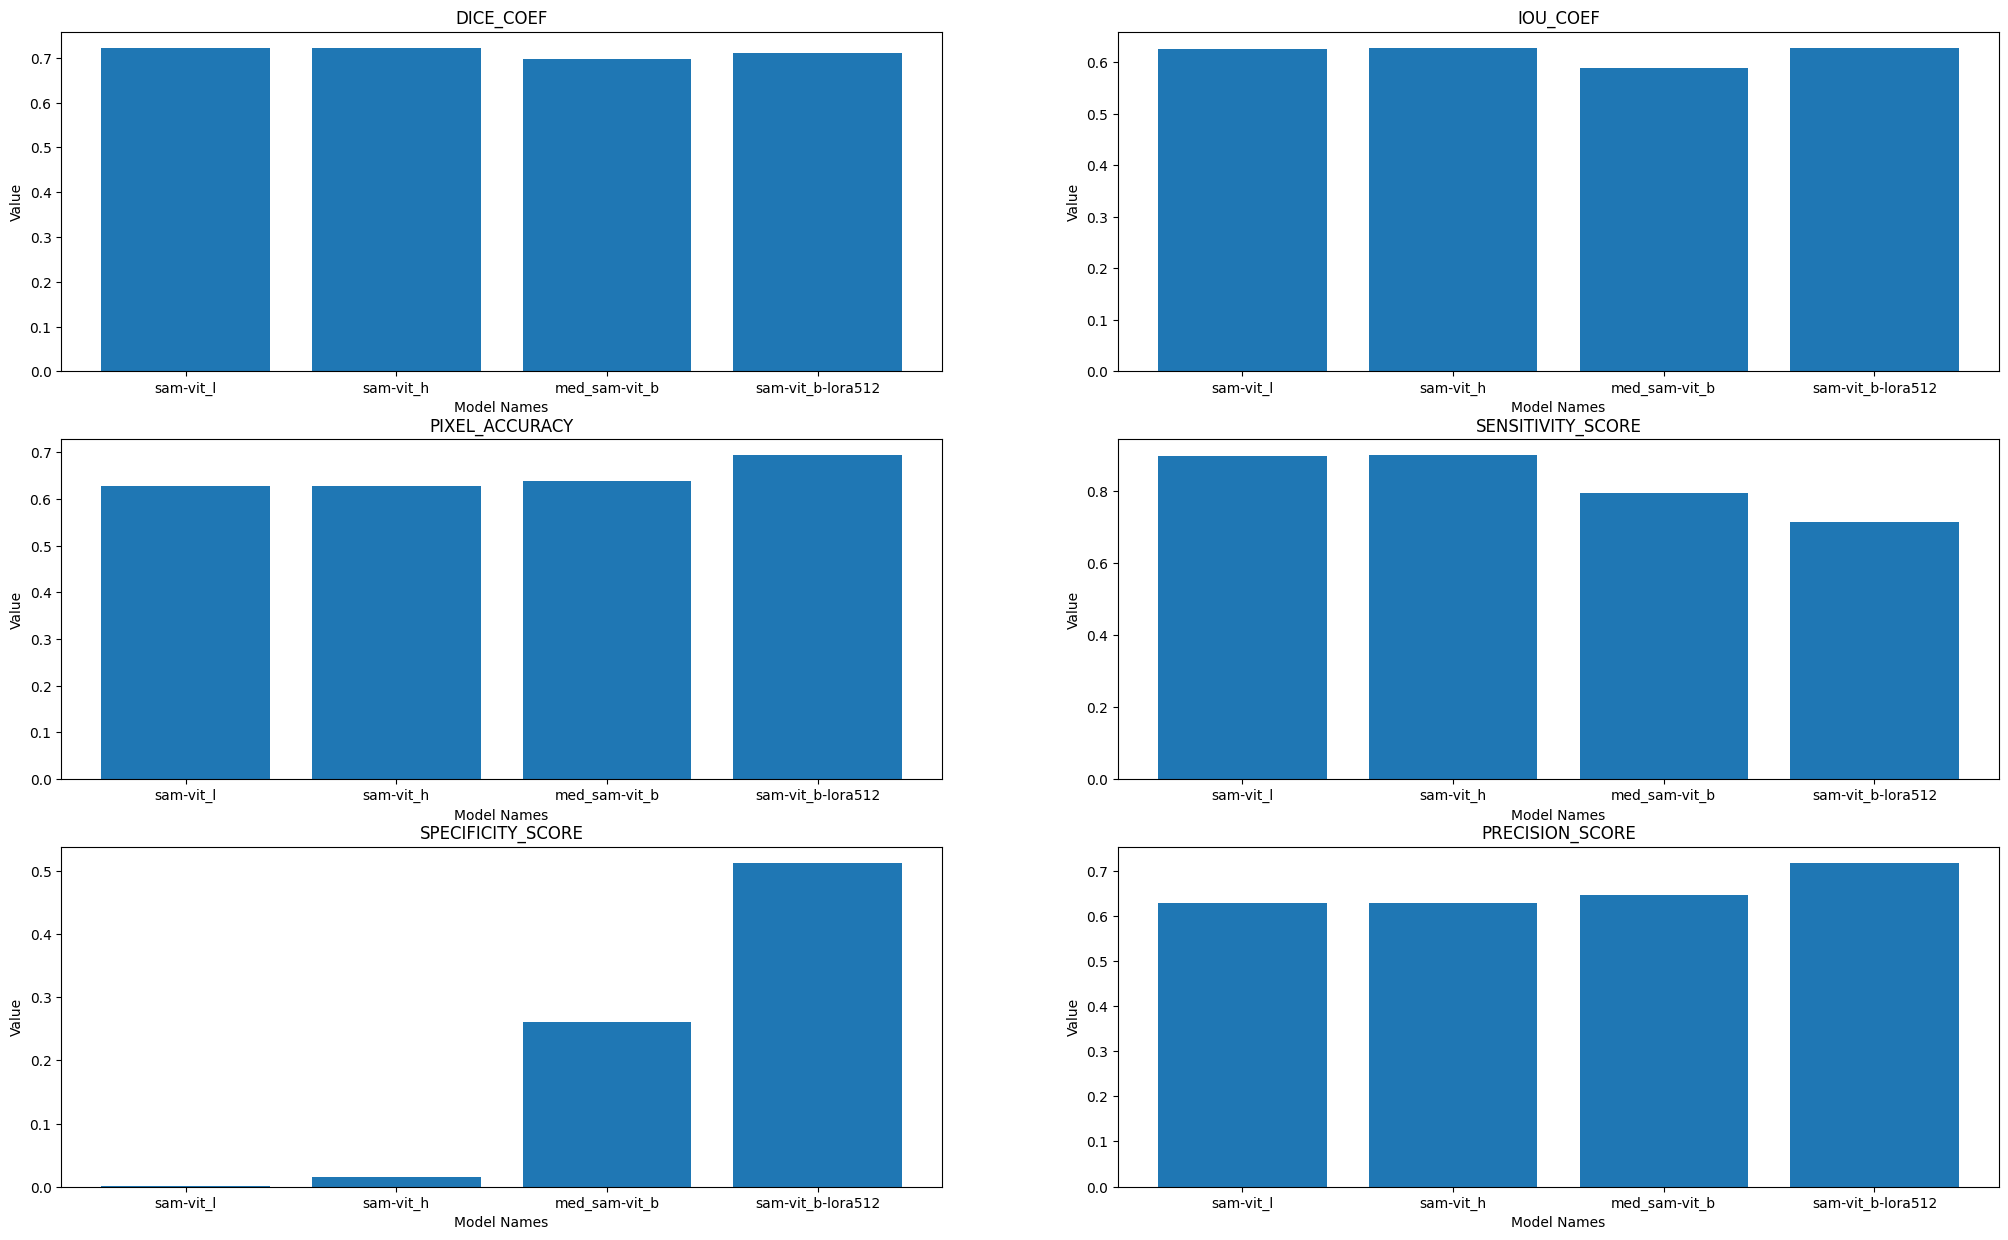

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25, 15))
for i in range(6):
    plt.subplot(3, 2, i+1)
    name = benchmark_fn_list[i].__name__
    # print(name)
    metric = metrics[name]
    # print(metric)
    plt.bar(models, metric)
    plt.title(name.upper())
    plt.xlabel("Model Names")
    plt.ylabel('Value')
plt.show()